# 05 - Hitra Fourierova transformacija (FFT)
<p style="font-weight: 600; text-align: center;">
Matematično-fizikalni praktikum, november 2023 <br>
Luka Skeledžija, 28201079
</p>

<style>
.MJXc-display{
    display: inline-block !important;
    width: 100%;
}
@media print {
    .pagebreak { page-break-before: always; } /* page-break-after works, as well */
}

img{
    width: 100%;
    max-width: 600px !important;
    margin: auto !important;
}

body {
    overflow: hidden;
    max-width: 600px;
    margin: auto;
}

::-webkit-scrollbar {
  width: 0px;
}

table{
    width: 100%;
}

h1 {
    text-transform: uppercase;
    text-align: center;
    background: #222222;
    color: white;
    padding: 8px;
}

blockquote {
    margin-left: 0em!important;
    margin-right: 0em!important;

}

.jp-RenderedHTMLCommon pre, .jp-RenderedHTMLCommon code {

    background-color: var(--jp-layout-color2)!important;
}

.jp-RenderedHTMLCommon pre{
    margin: 0.5em 0em!important;
    padding: 0em 1.5em!important;
}

body {
    counter-reset: h2counter;
}
h1 {
    counter-reset: h2counter;
}
h2:before {
    content: counter(h2counter) ".\0000a0\0000a0";
    counter-increment: h2counter;
    counter-reset: h3counter;
}
h3:before {
    counter-increment: h3counter;
    content: counter(h2counter) "." counter(h3counter) ".\0000a0\0000a0";
  
}




</style>


---

## Uvod

...

## Princip reševanja

In [3]:
# Standardized imports for MFPR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
import markdown
import datetime
import scipy.special as sp
import scipy.stats as stats
import scipy.optimize as opt
import scipy.interpolate as interp
from matplotlib import animation
import logging

# Function and constants defitition for Juptyer notebook (rerun for hot reload of imports)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams["grid.linestyle"]="dashed"
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

def log_msg(msg, log_filename='my_log_file.log'):
    # Configure the logging module if not already configured
    if not logging.root.handlers:
        logging.basicConfig(
            filename=log_filename,
            level=logging.DEBUG,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )

    # Create a logger for the function (you can replace 'my_function' with your desired logger name)
    logger = logging.getLogger('EIGENSTATES')

    # Log the provided message
    logger.info(msg)
def clear_log_file(log_filename='my_log_file.log'):
    with open(log_filename, 'w'):
        pass

def centerHTML(html, text=""):
    text = markdown.markdown(text)
    return '<div style="display: flex; align-items: center; flex-direction: column;">' + html + f'</div><div style="display: flex; align-items: center; flex-direction: column;padding-top: 15px;"><small style="max-width: 600px">{text}</small></div>'

def insertHTMLVideo(filename, text=""):
    return centerHTML(f'<video controls src="{filename}" style="max-width: 600px;width:100%"></video>', text)


clear_log_file()
log_msg('START logging...')


## Naloga


In [4]:
from scipy.io import wavfile

p1, bubo = wavfile.read('./data/bubomono.wav')
p2, bubo2 = wavfile.read('./data/bubo2mono.wav')
p3, mix = wavfile.read('./data/mix.wav')
p4, mix1 = wavfile.read('./data/mix1.wav')
p5, mix2 = wavfile.read('./data/mix2.wav')
p6, mix22 = wavfile.read('./data/mix22.wav')

data = [bubo, bubo2, mix, mix1, mix2, mix22]
sampling = [p1, p2, p3, p4, p5, p6]
names = ['bubo', 'bubo2', 'mix', 'mix1', 'mix2', 'mix22']



### Spektrogram

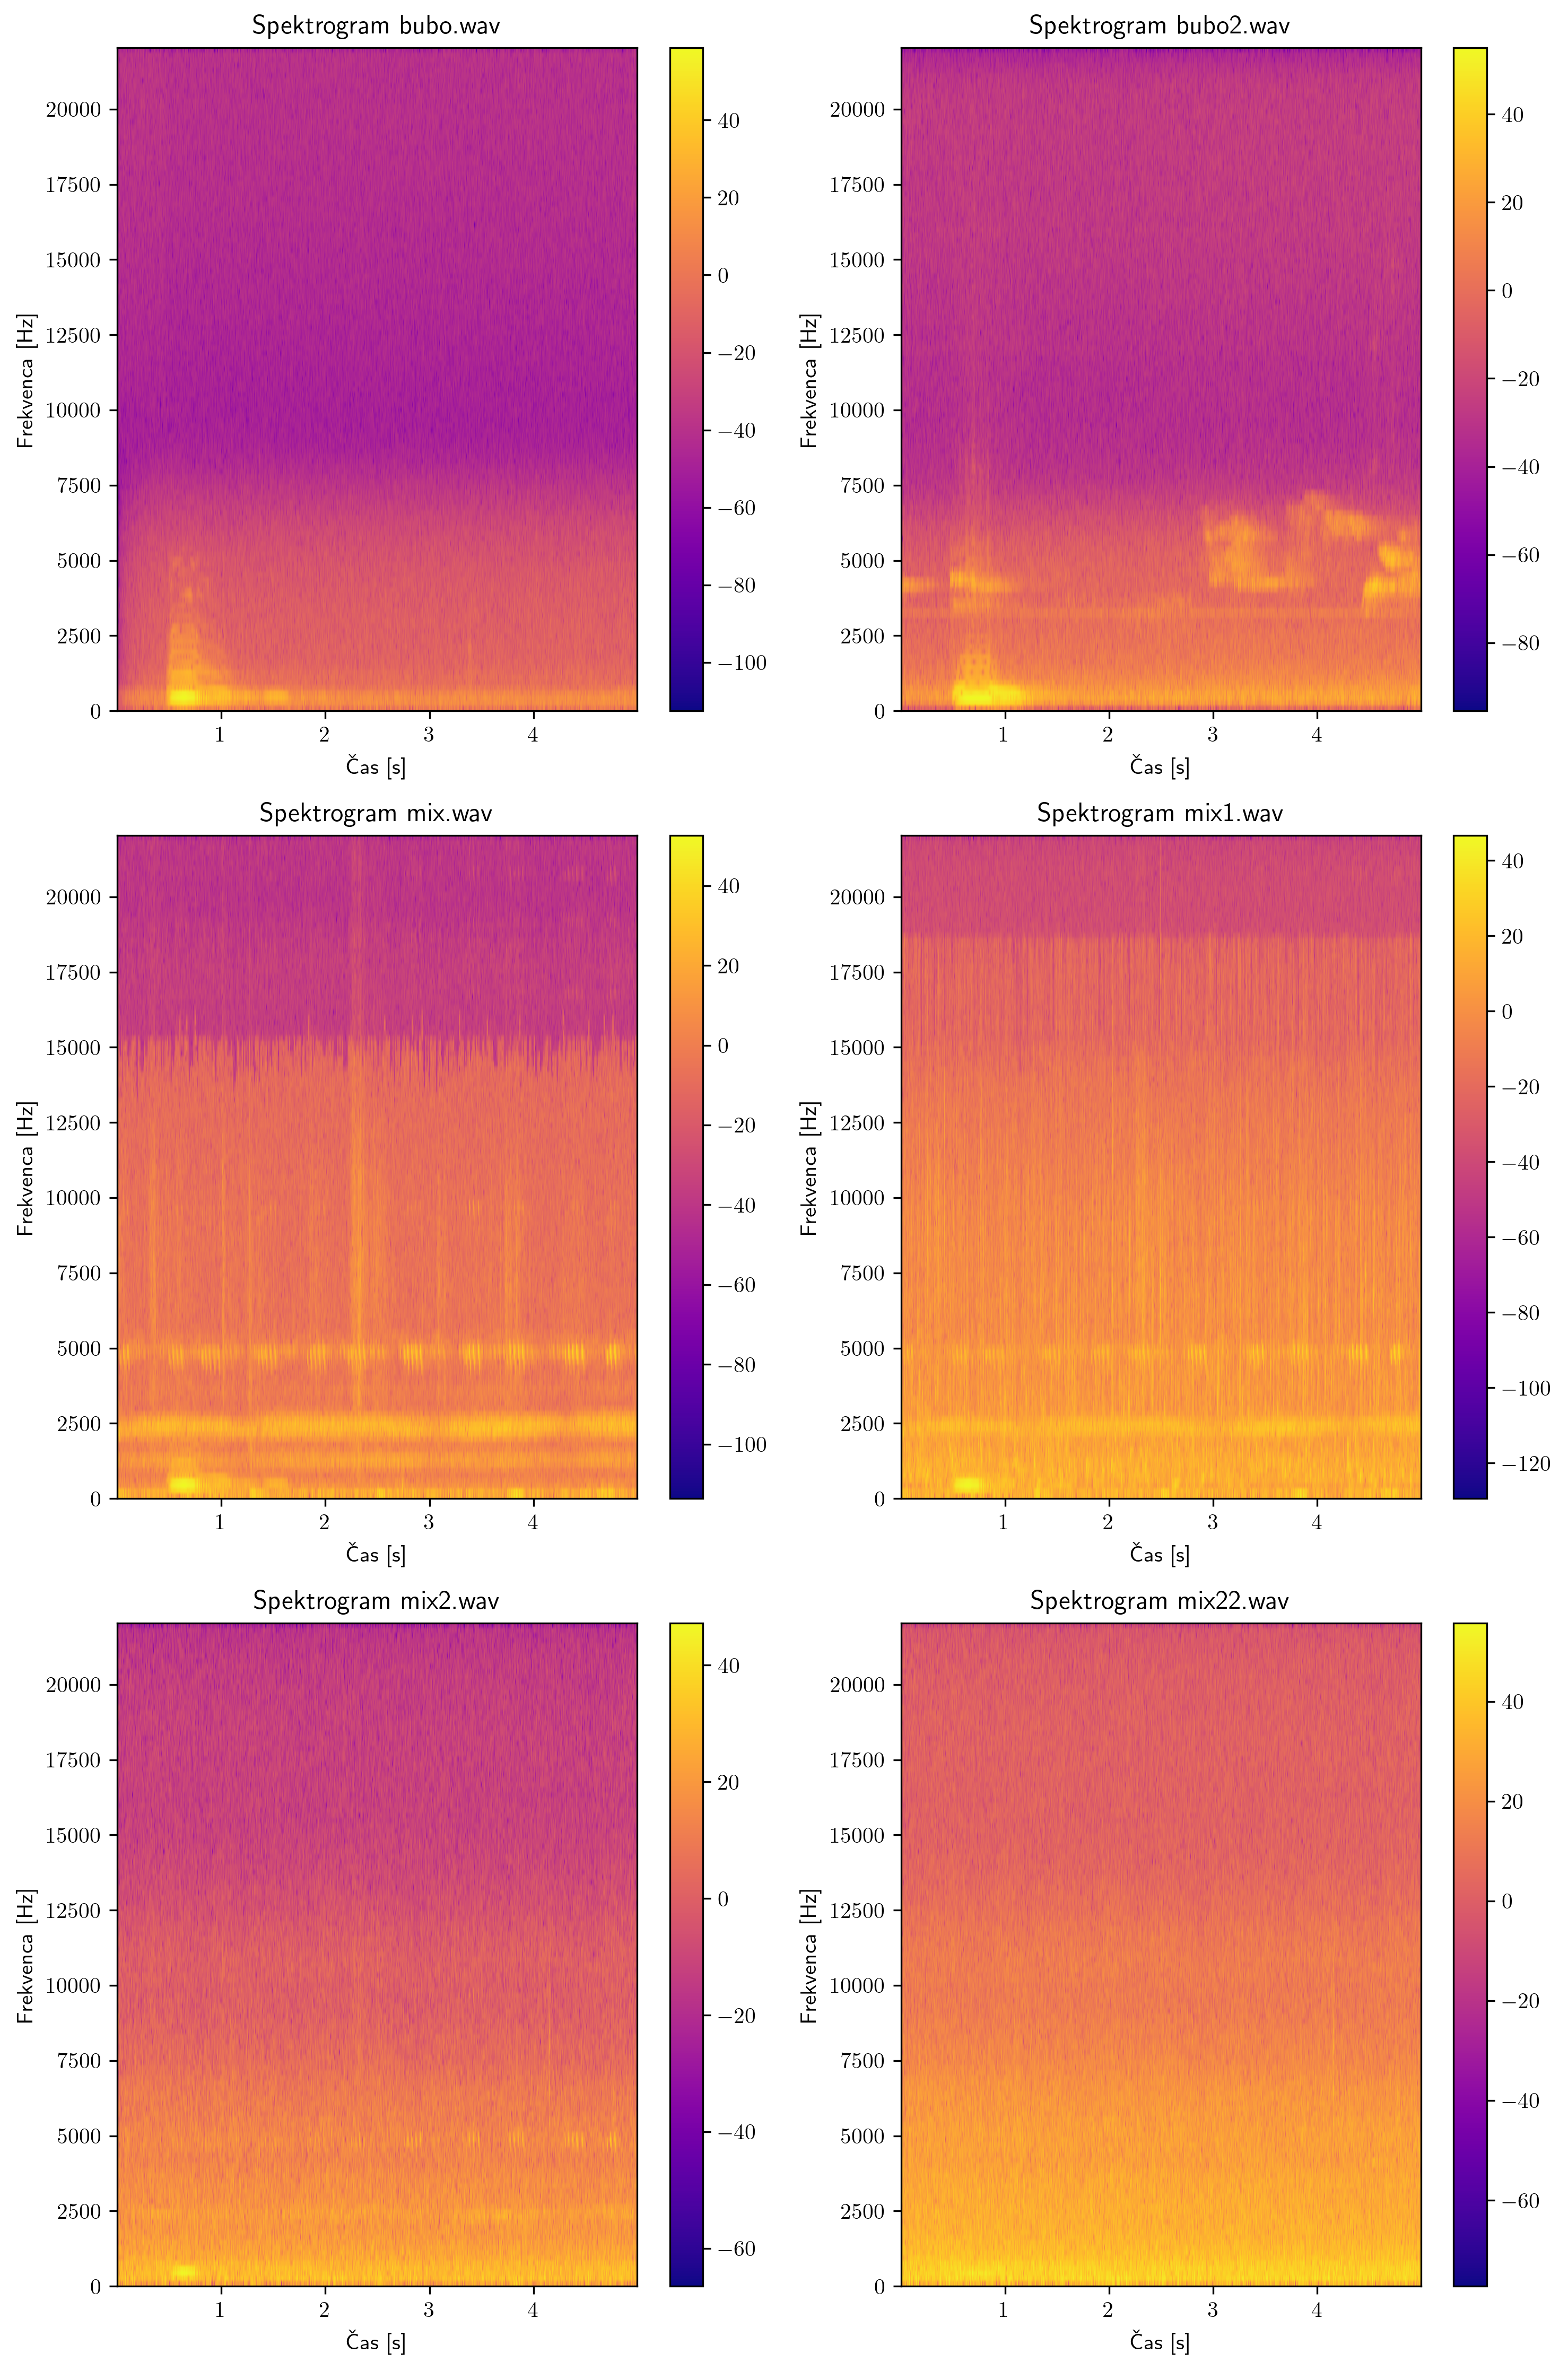

In [5]:
#Spectrogram
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()

norm = 1

for i, ax in enumerate(axes):
    d = data[i] / norm
    sample_rate = sampling[i]
    pxx, freqs, bins, im = ax.specgram(d, Fs=sample_rate, cmap='plasma')
    ax.set_title(f'Spektrogram {names[i]}.wav')
    ax.set_xlabel('Čas [s]')
    ax.set_ylabel('Frekvenca [Hz]')
    fig.colorbar(im, ax=ax)

plt.tight_layout()


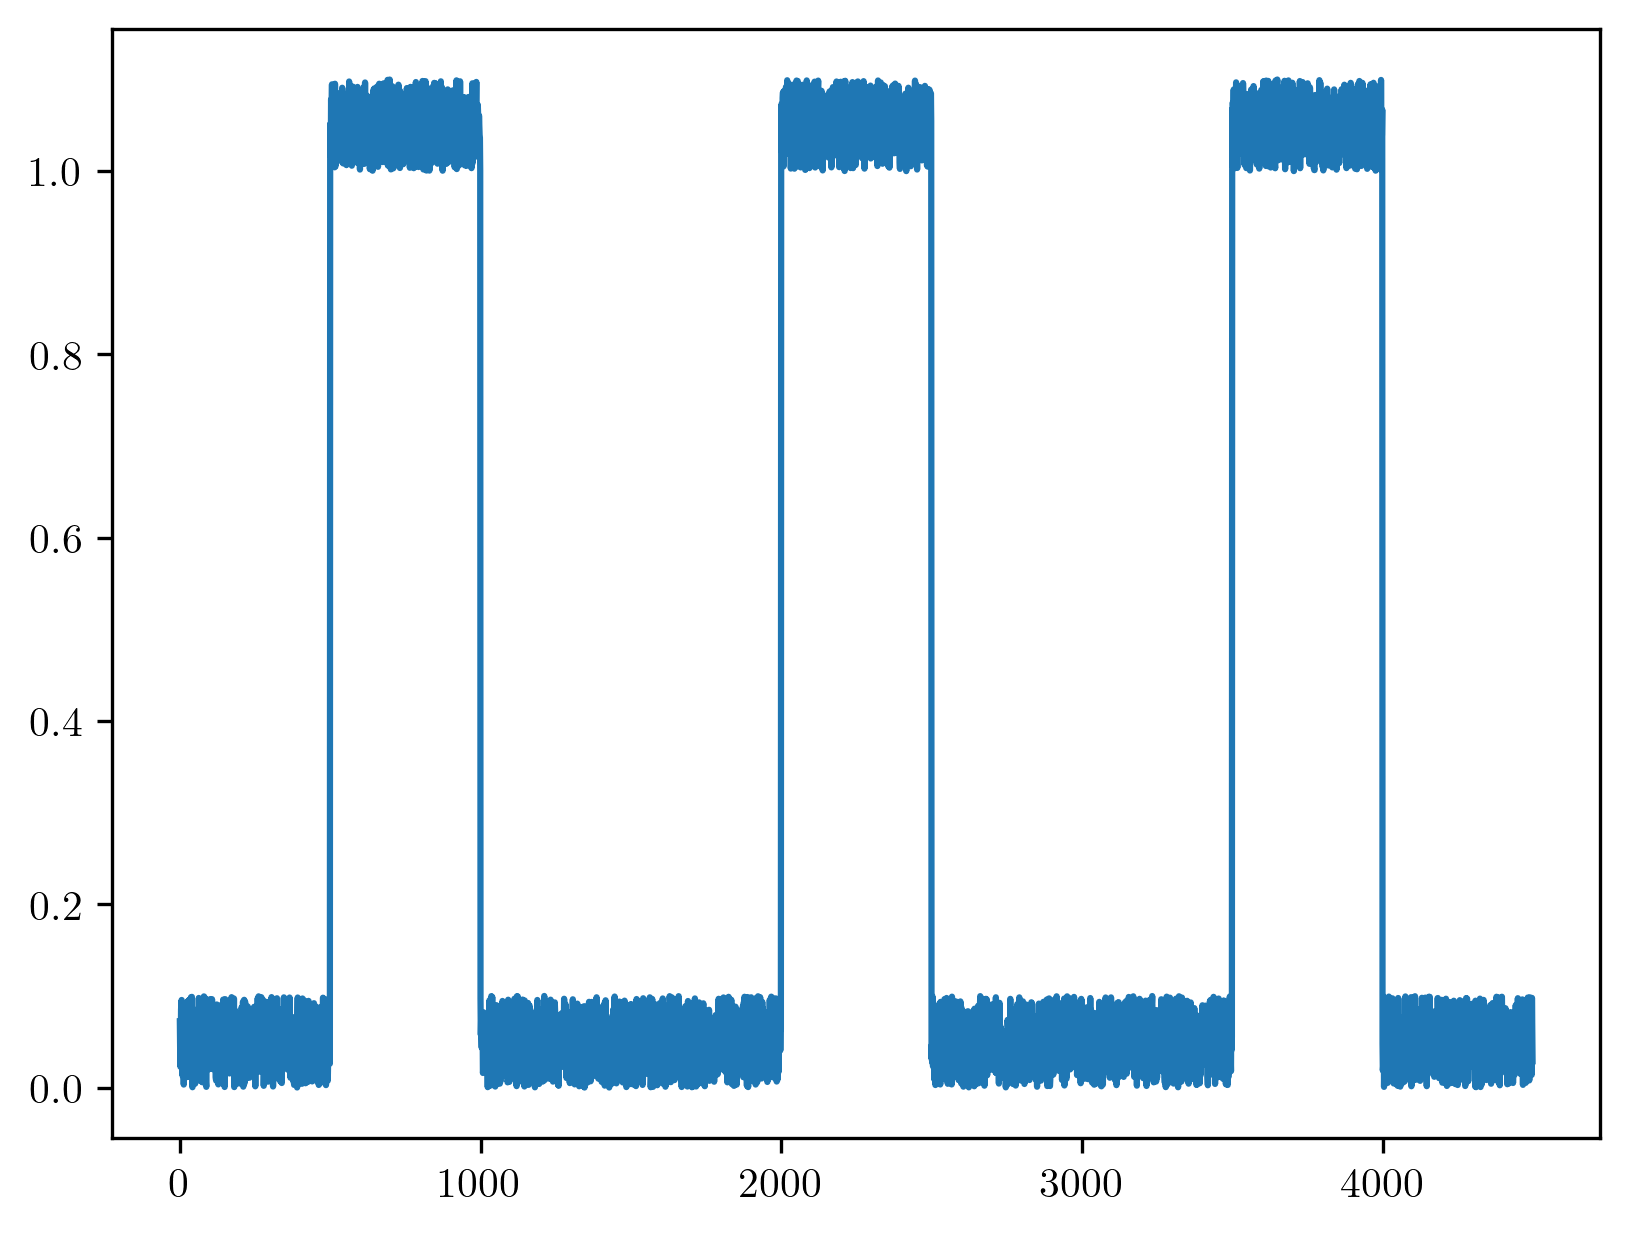

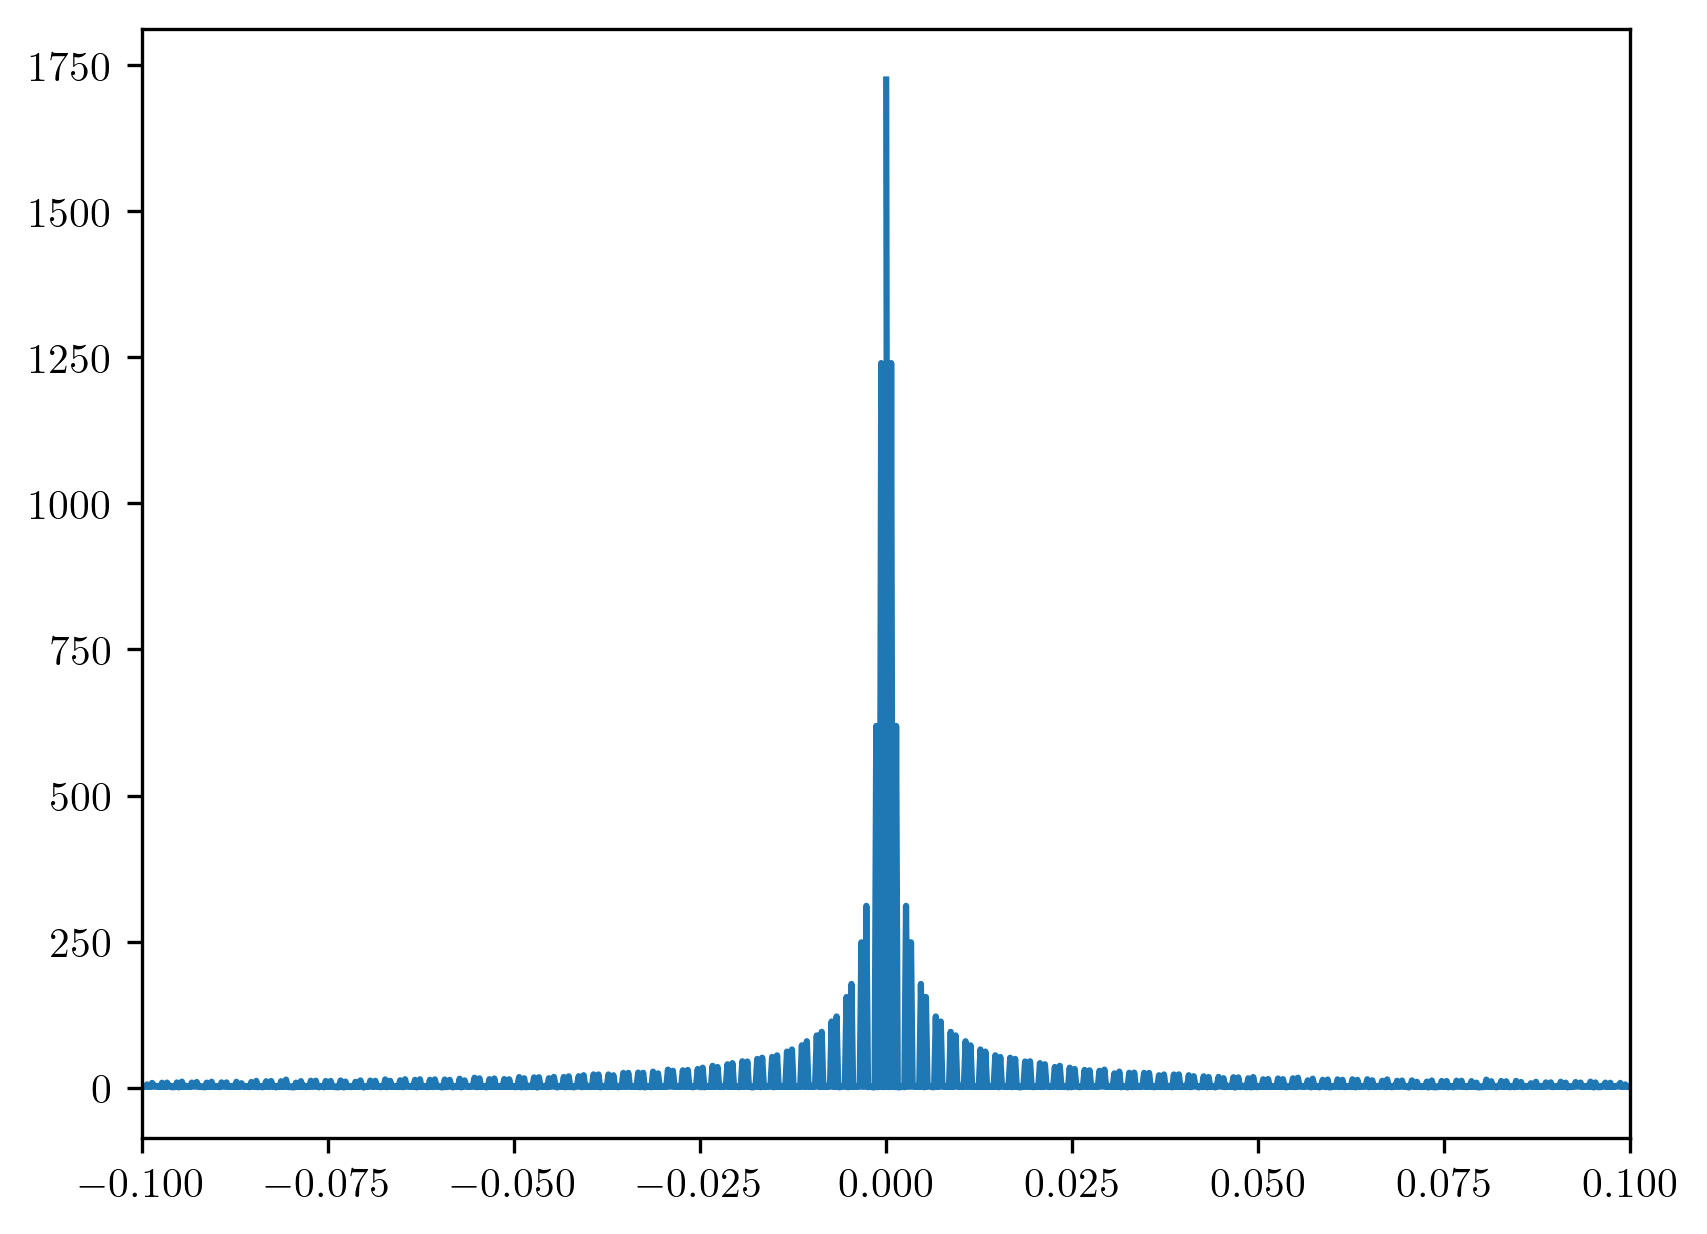

/Users/luka/.pyenv/versions/3.11.2/envs/phys/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/luka/.pyenv/versions/3.11.2/envs/phys/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


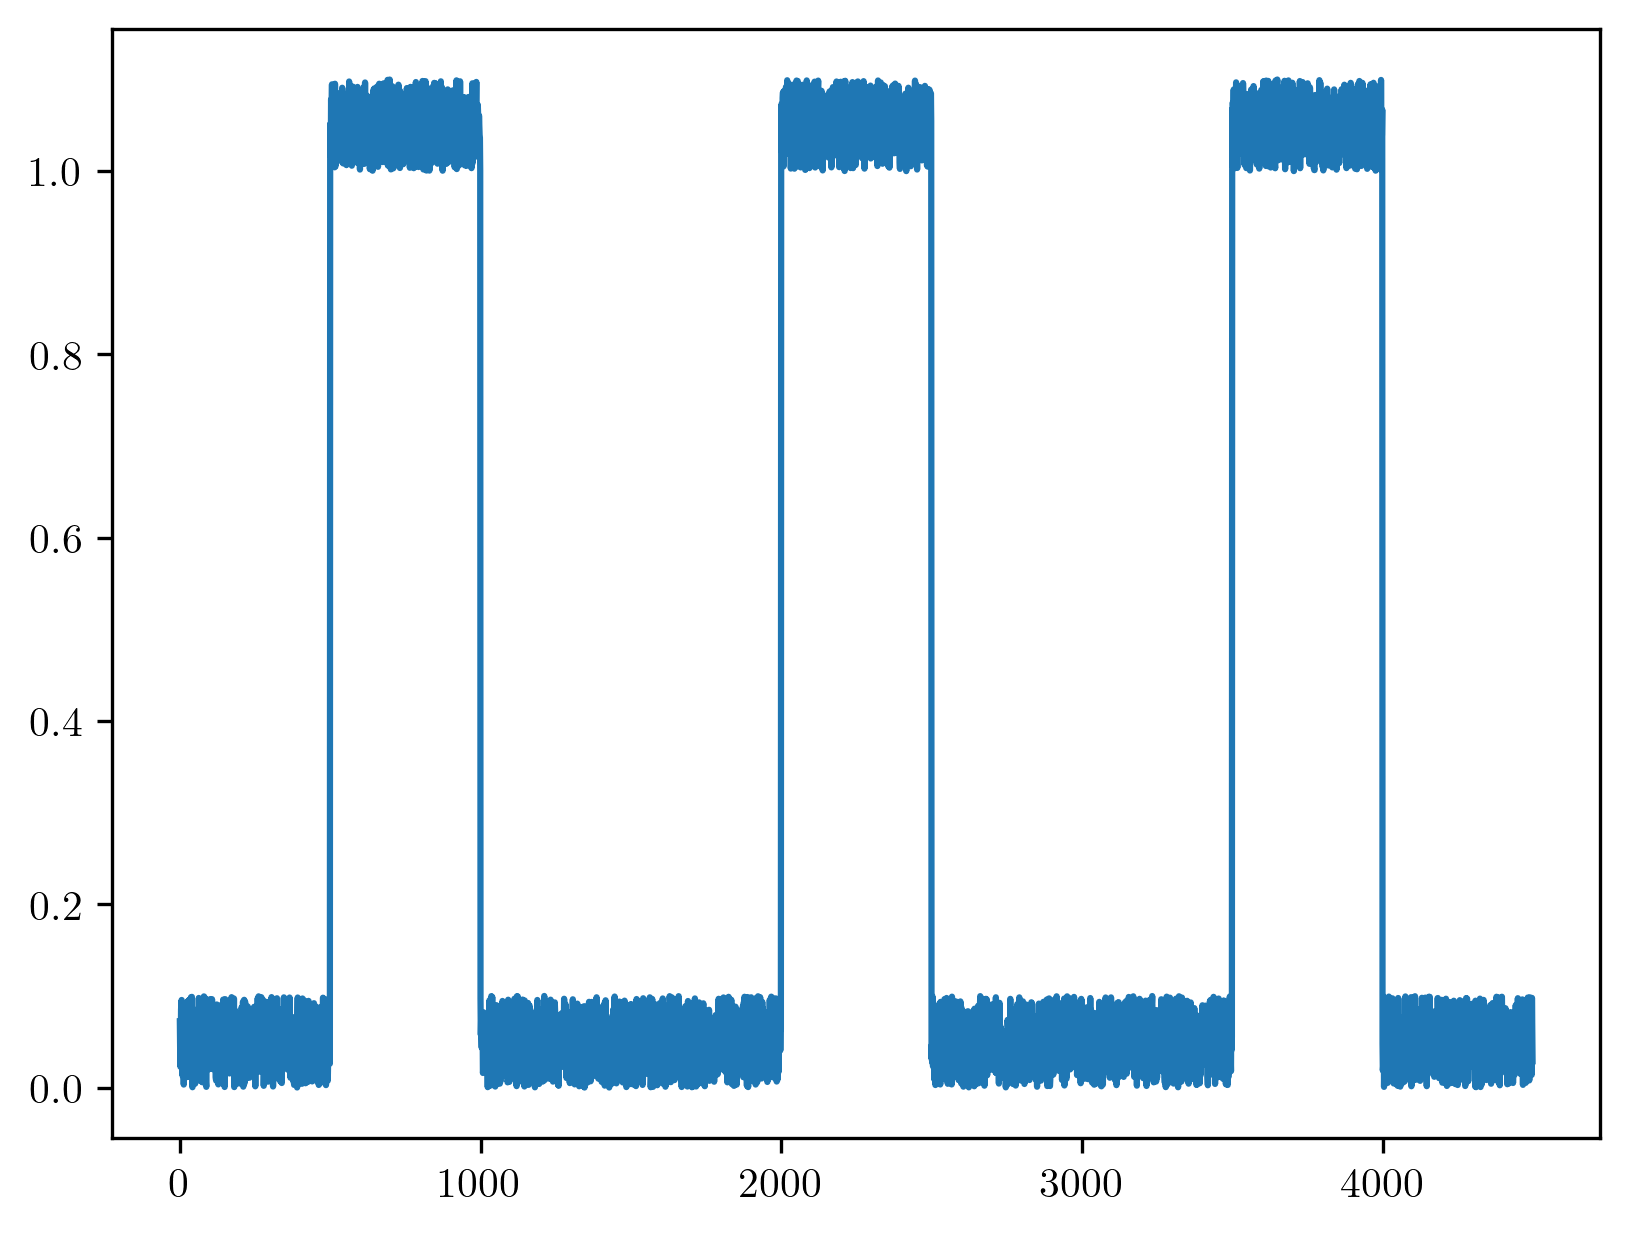

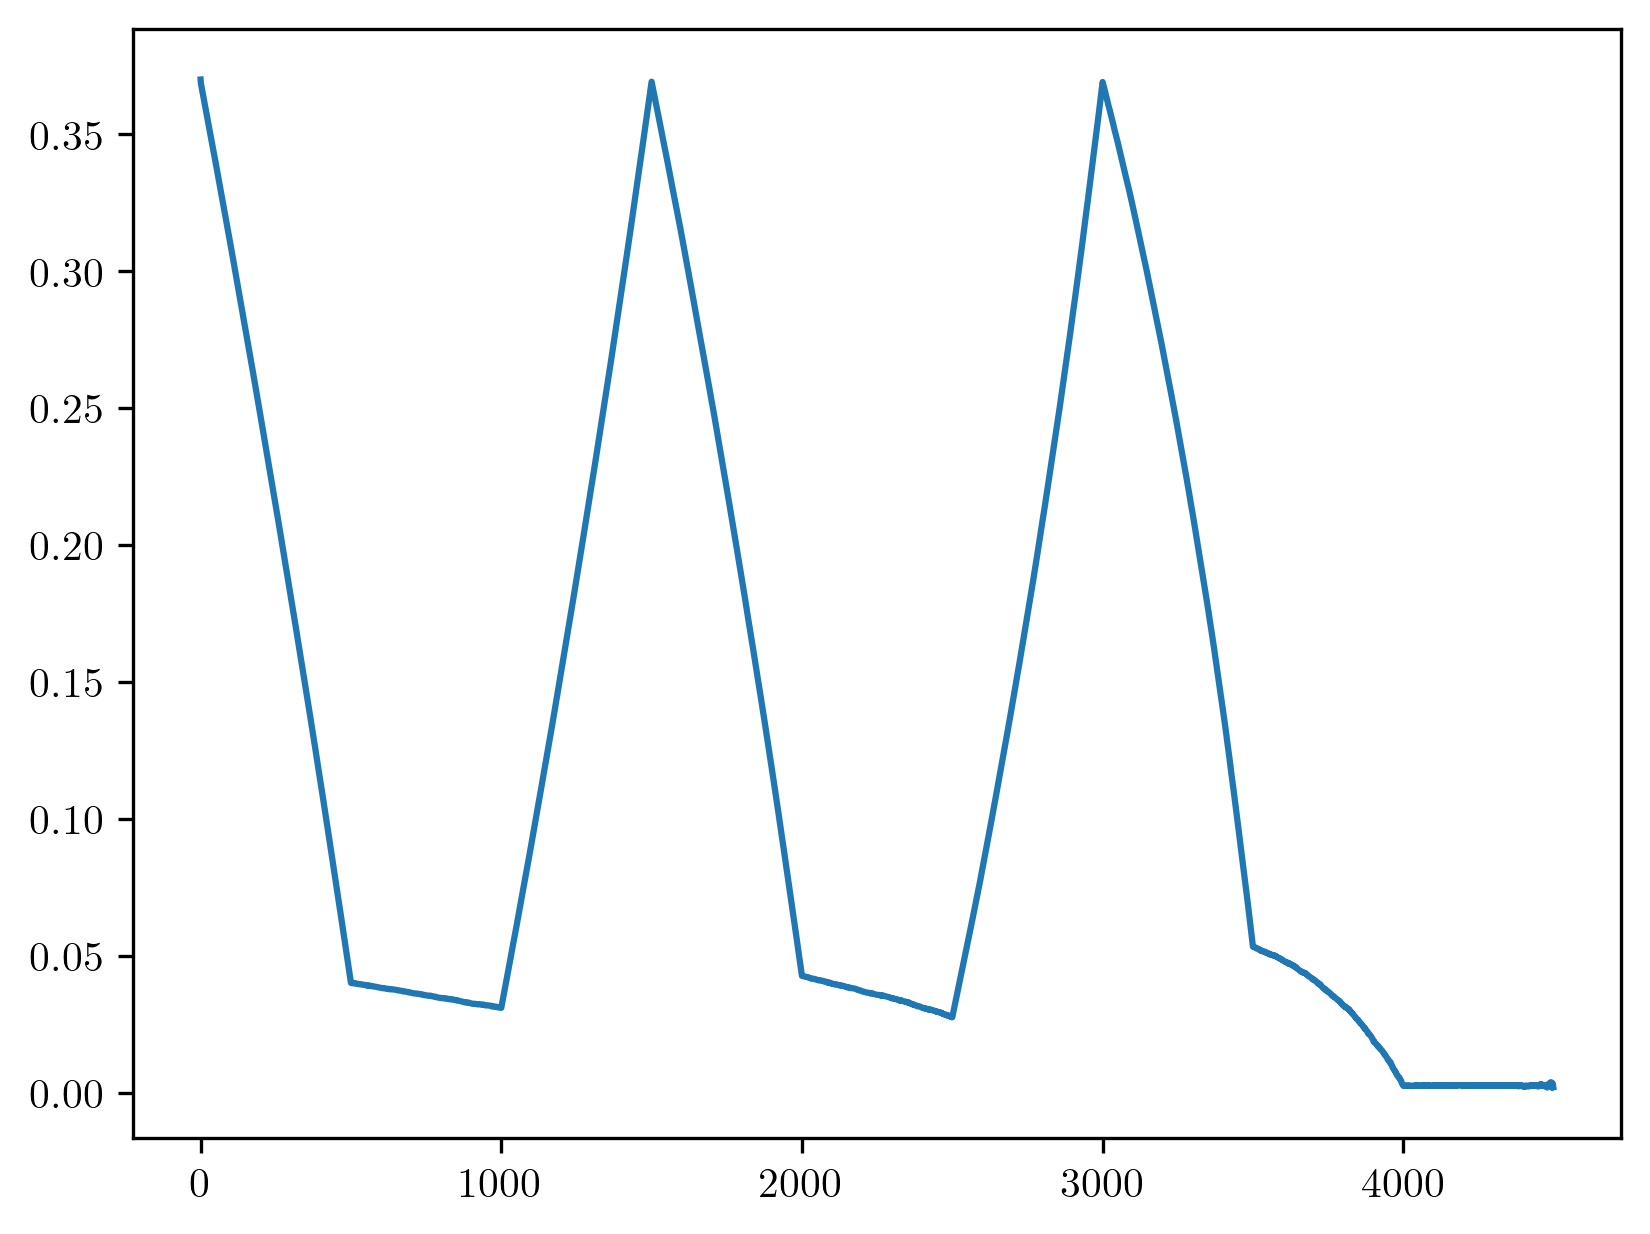

In [6]:
def FFT(x, fs, N=0, shift=False):
    if N == 0:
        N = len(x)
    X = np.fft.fft(x, N)
    f = np.fft.fftfreq(N, 1/fs)
    if shift:
        X = np.fft.fftshift(X)
        f = np.fft.fftshift(f)
    return X, f

def IFFT(X, fs, N=0):
    if N == 0:
        N = len(X)
    x = np.fft.ifft(X, N)
    t = np.fft.fftfreq(N, 1/fs)
    return x, t

def h_tilda(h, n):
    h_tilda = np.roll(h, -n)
    h_tilda = np.hstack( (h_tilda, np.zeros_like(h_tilda)) )
    return h_tilda    

def autocorr(n, h_data):
    ampl = h_data
    N = ampl.shape[0]
    h_k = h_tilda(ampl, 0)
    h_kn = h_tilda(ampl, n)
    fi_nn = (1 / (N - n) ) * np.dot(h_k, h_kn)
    return fi_nn

def autocorr_rescaled(n, h_data, fs):
    fft_ampl, freq = FFT(h_data, fs)
    fi_n = autocorr(n, fft_ampl, fs)
    fi_0 = autocorr(np.zeros_like(n), fft_ampl, fs)
    avg_h_sqr = np.mean(h_data)**2
    return (fi_n - avg_h_sqr) / (fi_0 - avg_h_sqr)

def roll_n_pad(h, n):
    N = len(h)
    h_tilda = np.roll(h, -n)
    h_tilda = np.hstack( (h_tilda, np.zeros_like(h_tilda)) )
    return h_tilda

def auto_corr_def(h_data):
    N = h_data.shape[0]
    ns = np.arange(N)
    autocorr_points = []
    for n in ns:
        A = 1 / (N - n)
        sum = 0
        for i in range(N - n):
            sum += h_data[i] * h_data[i + n]
        autocorr_points.append(A * sum)
    return autocorr_points, ns




# bubo_x, bubo_f = FFT(bubo, p1)
# bubo2_x, bubo2_f = FFT(bubo2, p2)
# mix_x, mix_f = FFT(mix, p3)

barret = np.ones(500)
barret = np.hstack( (np.zeros_like(barret), barret, np.zeros_like(barret)) )
barret = np.hstack( (barret, barret, barret) )
rand_v = np.random.rand(len(barret))
barret = barret + rand_v * 0.1

barret_x, barret_f = FFT(barret, 1, len(barret))
barret_ix, barret_it = IFFT(barret_x, 1, len(barret_x))

#Plot default
plt.plot(barret)
plt.show()
#Plot FFT
plt.plot(barret_f, np.abs(barret_x))
plt.xlim(-0.1, 0.1)
plt.show()
#Plot IFFT
plt.plot(barret_ix)
plt.show()
#Plot autocorr
barret_auto, barret_ns = auto_corr_def(barret)
plt.plot(barret_auto)
plt.show()



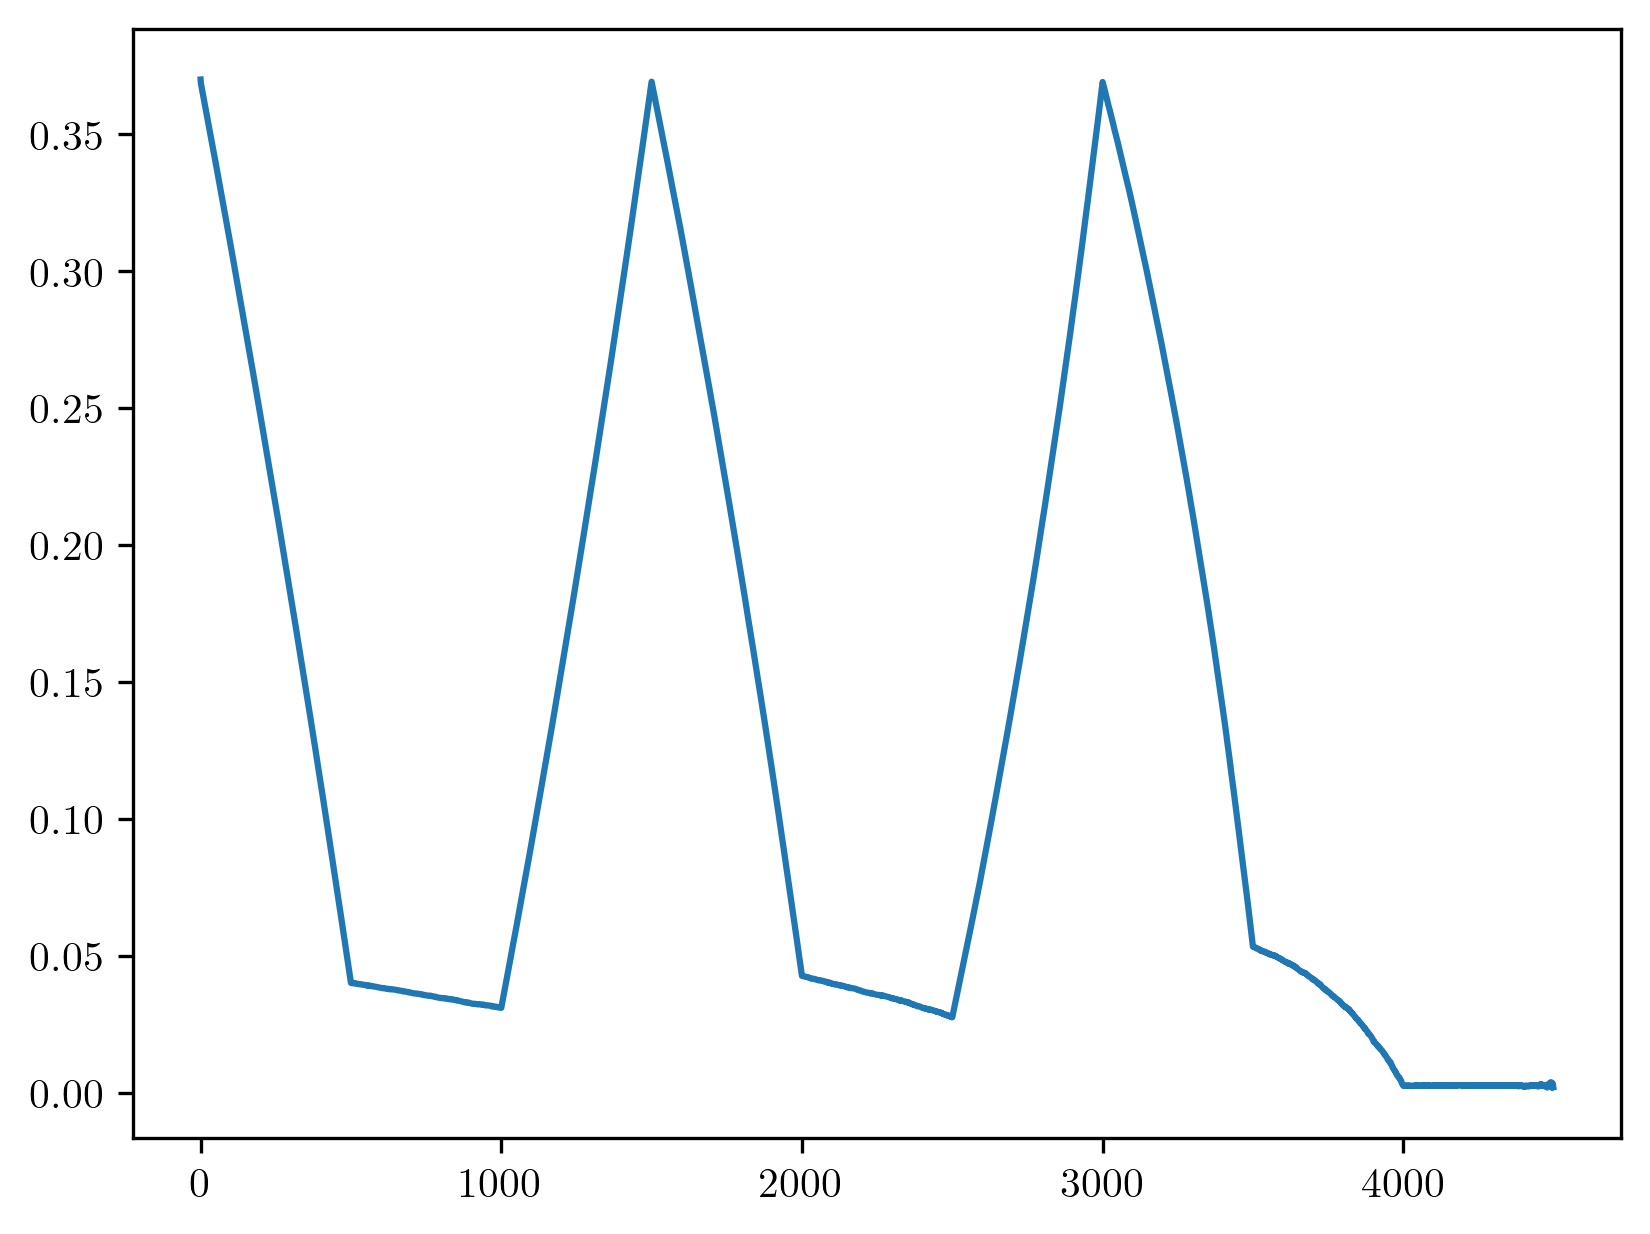

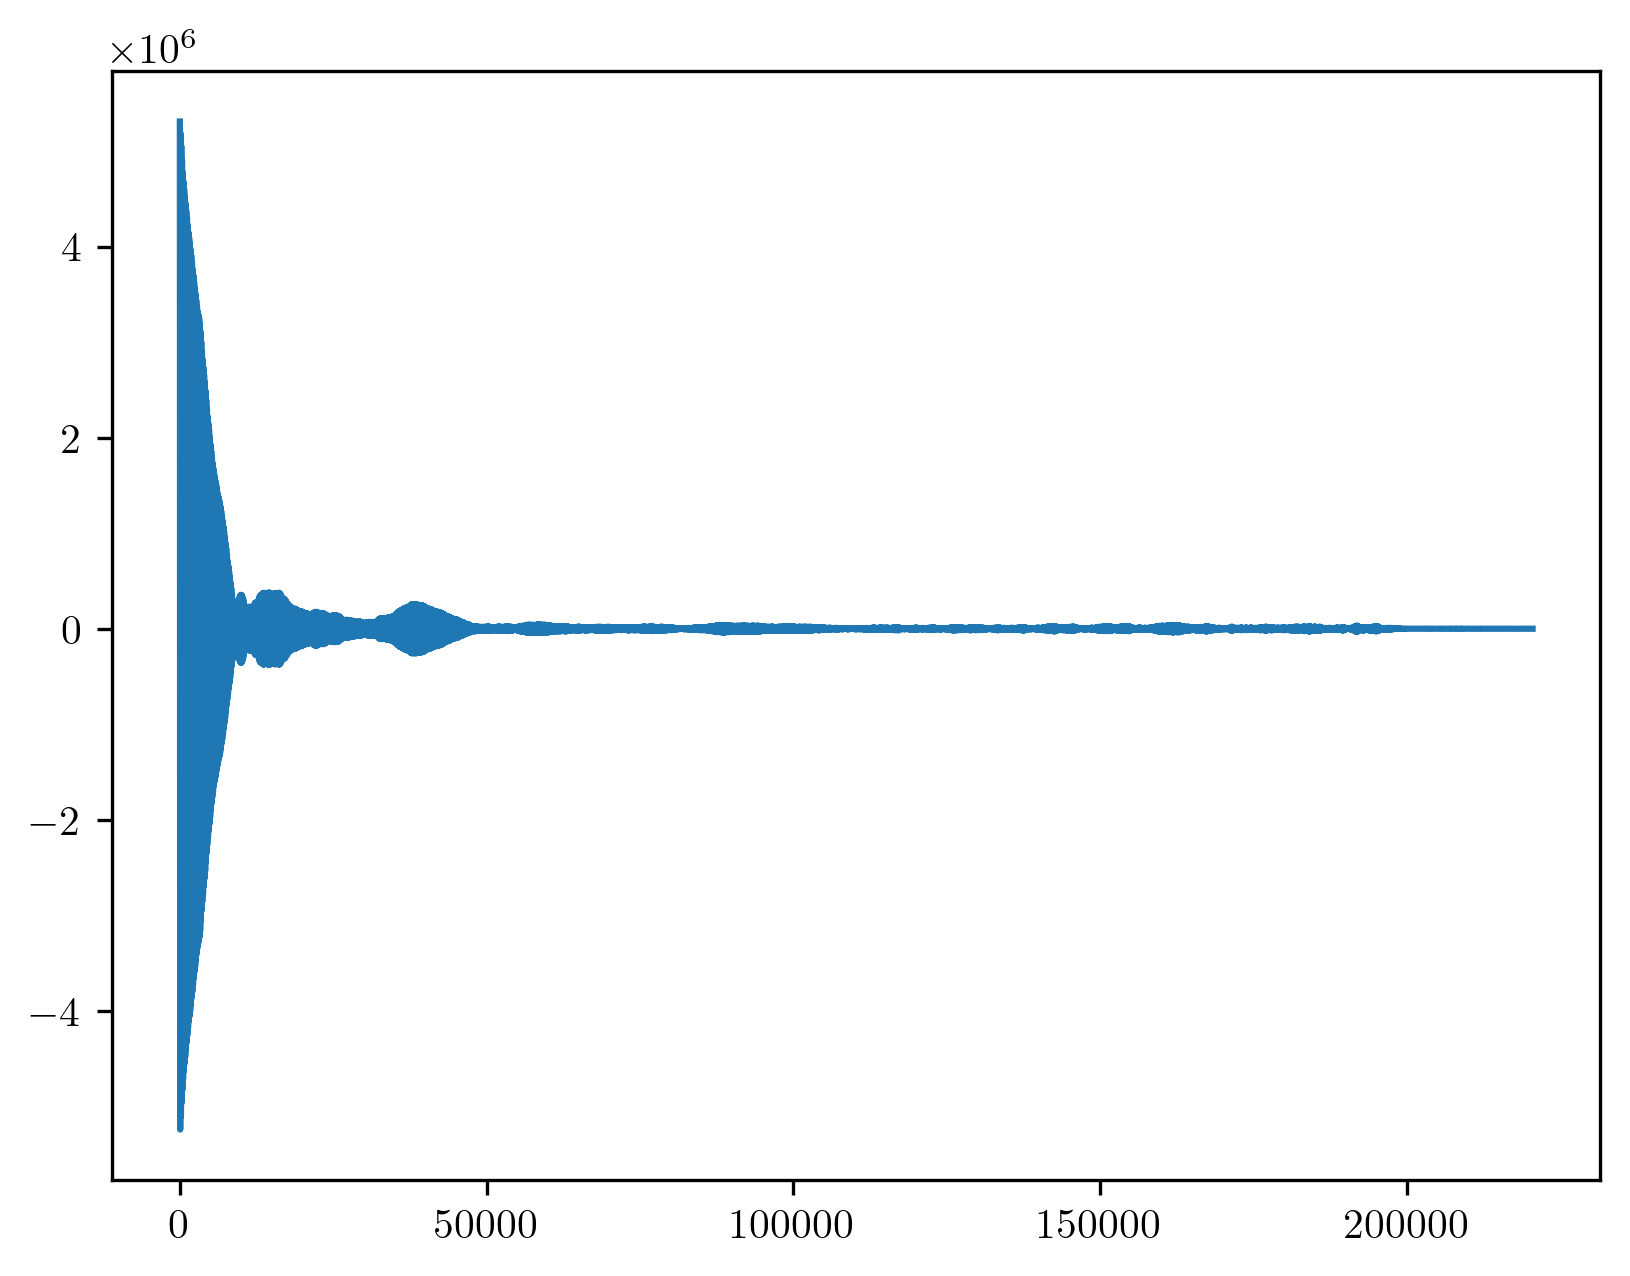

In [7]:
def pad_data(data):
    N = len(data)
    pad = np.zeros(N)
    return np.hstack((data, pad))

def auto_corr_np_def(h_data):
    N = h_data.shape[0]
    ns = np.arange(N)
    autocorr_points = []
    h_pad = pad_data(h_data)
    for n in ns:
        A = 1 / (N - n)
        h_pad = pad_data(h_data)
        h_pad_roll = np.roll(h_pad, n)
        out = A * np.dot(h_pad, h_pad_roll)
        autocorr_points.append(out)
    return autocorr_points, ns

def auto_corr_fft(h_data, minus_n = True):
    N = h_data.shape[0]
    ns = np.arange(N)
    autocorr_points = []
    h_pad = pad_data(h_data)
    h_fft, h_freqs = FFT(h_pad, 1)
    h_fft, h_freqs = IFFT(np.abs(h_fft)**2, 1)
    for n in ns:
        A = 1 / (N)
        if minus_n:
            A = 1 / (N - n)
        out = A * h_fft[n]
        autocorr_points.append(out)
    return autocorr_points, ns

def auto_corr_fft_time(h_data):
    ac_fft, ns_fft = auto_corr_fft(h_data, minus_n=False)
    h_mean = np.mean(h_data)
    return (ac_fft - h_mean**2) / (ac_fft[0] - h_mean**2), ns_fft


ac, ns = auto_corr_np_def(barret)
plt.plot(ac)
plt.show()


ac_fft, ns_fft = auto_corr_fft(bubo)
plt.plot(ac_fft)
plt.show()

    

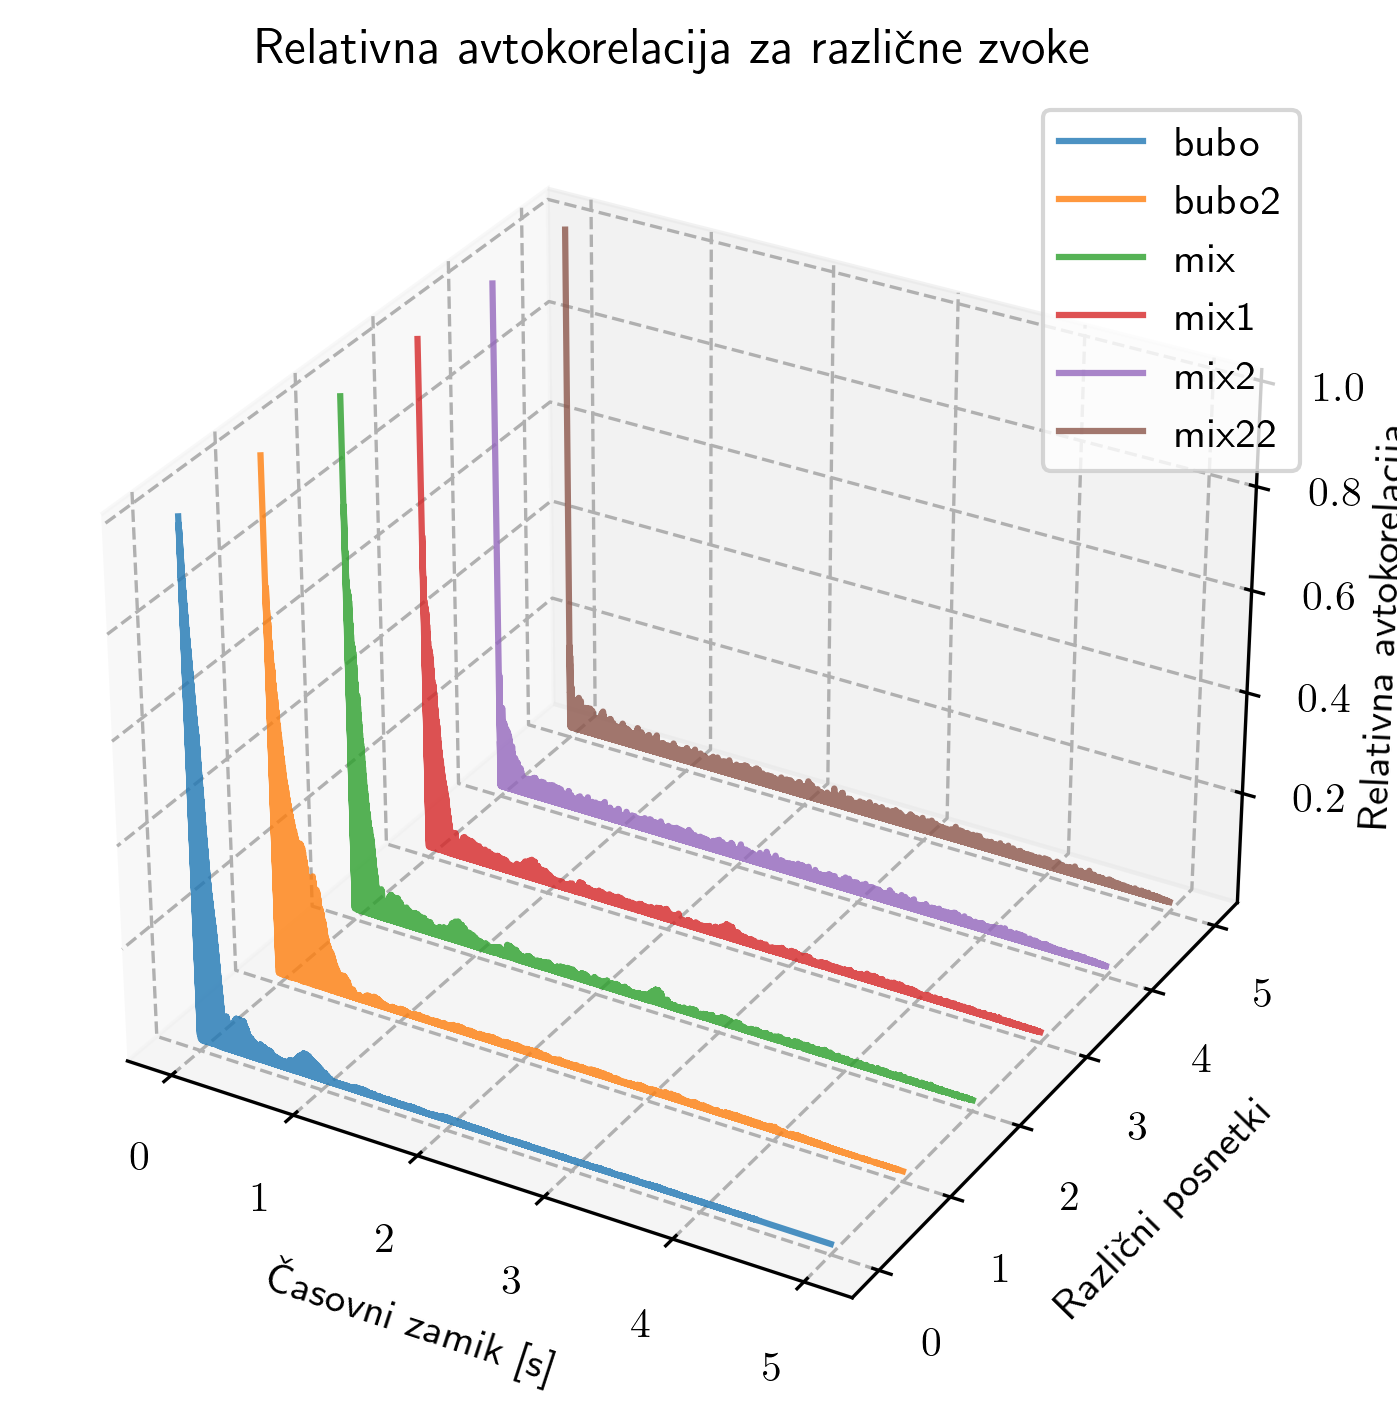

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

yticks = np.arange(6)
for i, in zip(yticks):
    sample_rate = sampling[i]
    ac_fft, ns_fft = auto_corr_fft_time(data[i])
    ac_fft = np.abs(ac_fft)
    ax.plot(ns_fft / sample_rate, ac_fft, zs=i, zdir='y', alpha=0.8, label=names[i])

ax.set_xlabel('Časovni zamik [s]')
ax.set_zlabel('Relativna avtokorelacija')
ax.set_ylabel('Različni posnetki')
ax.legend()
ax.zaxis.labelpad=-0.9 # <- change the value here


plt.title('Relativna avtokorelacija za različne zvoke')
plt.tight_layout()
plt.show()

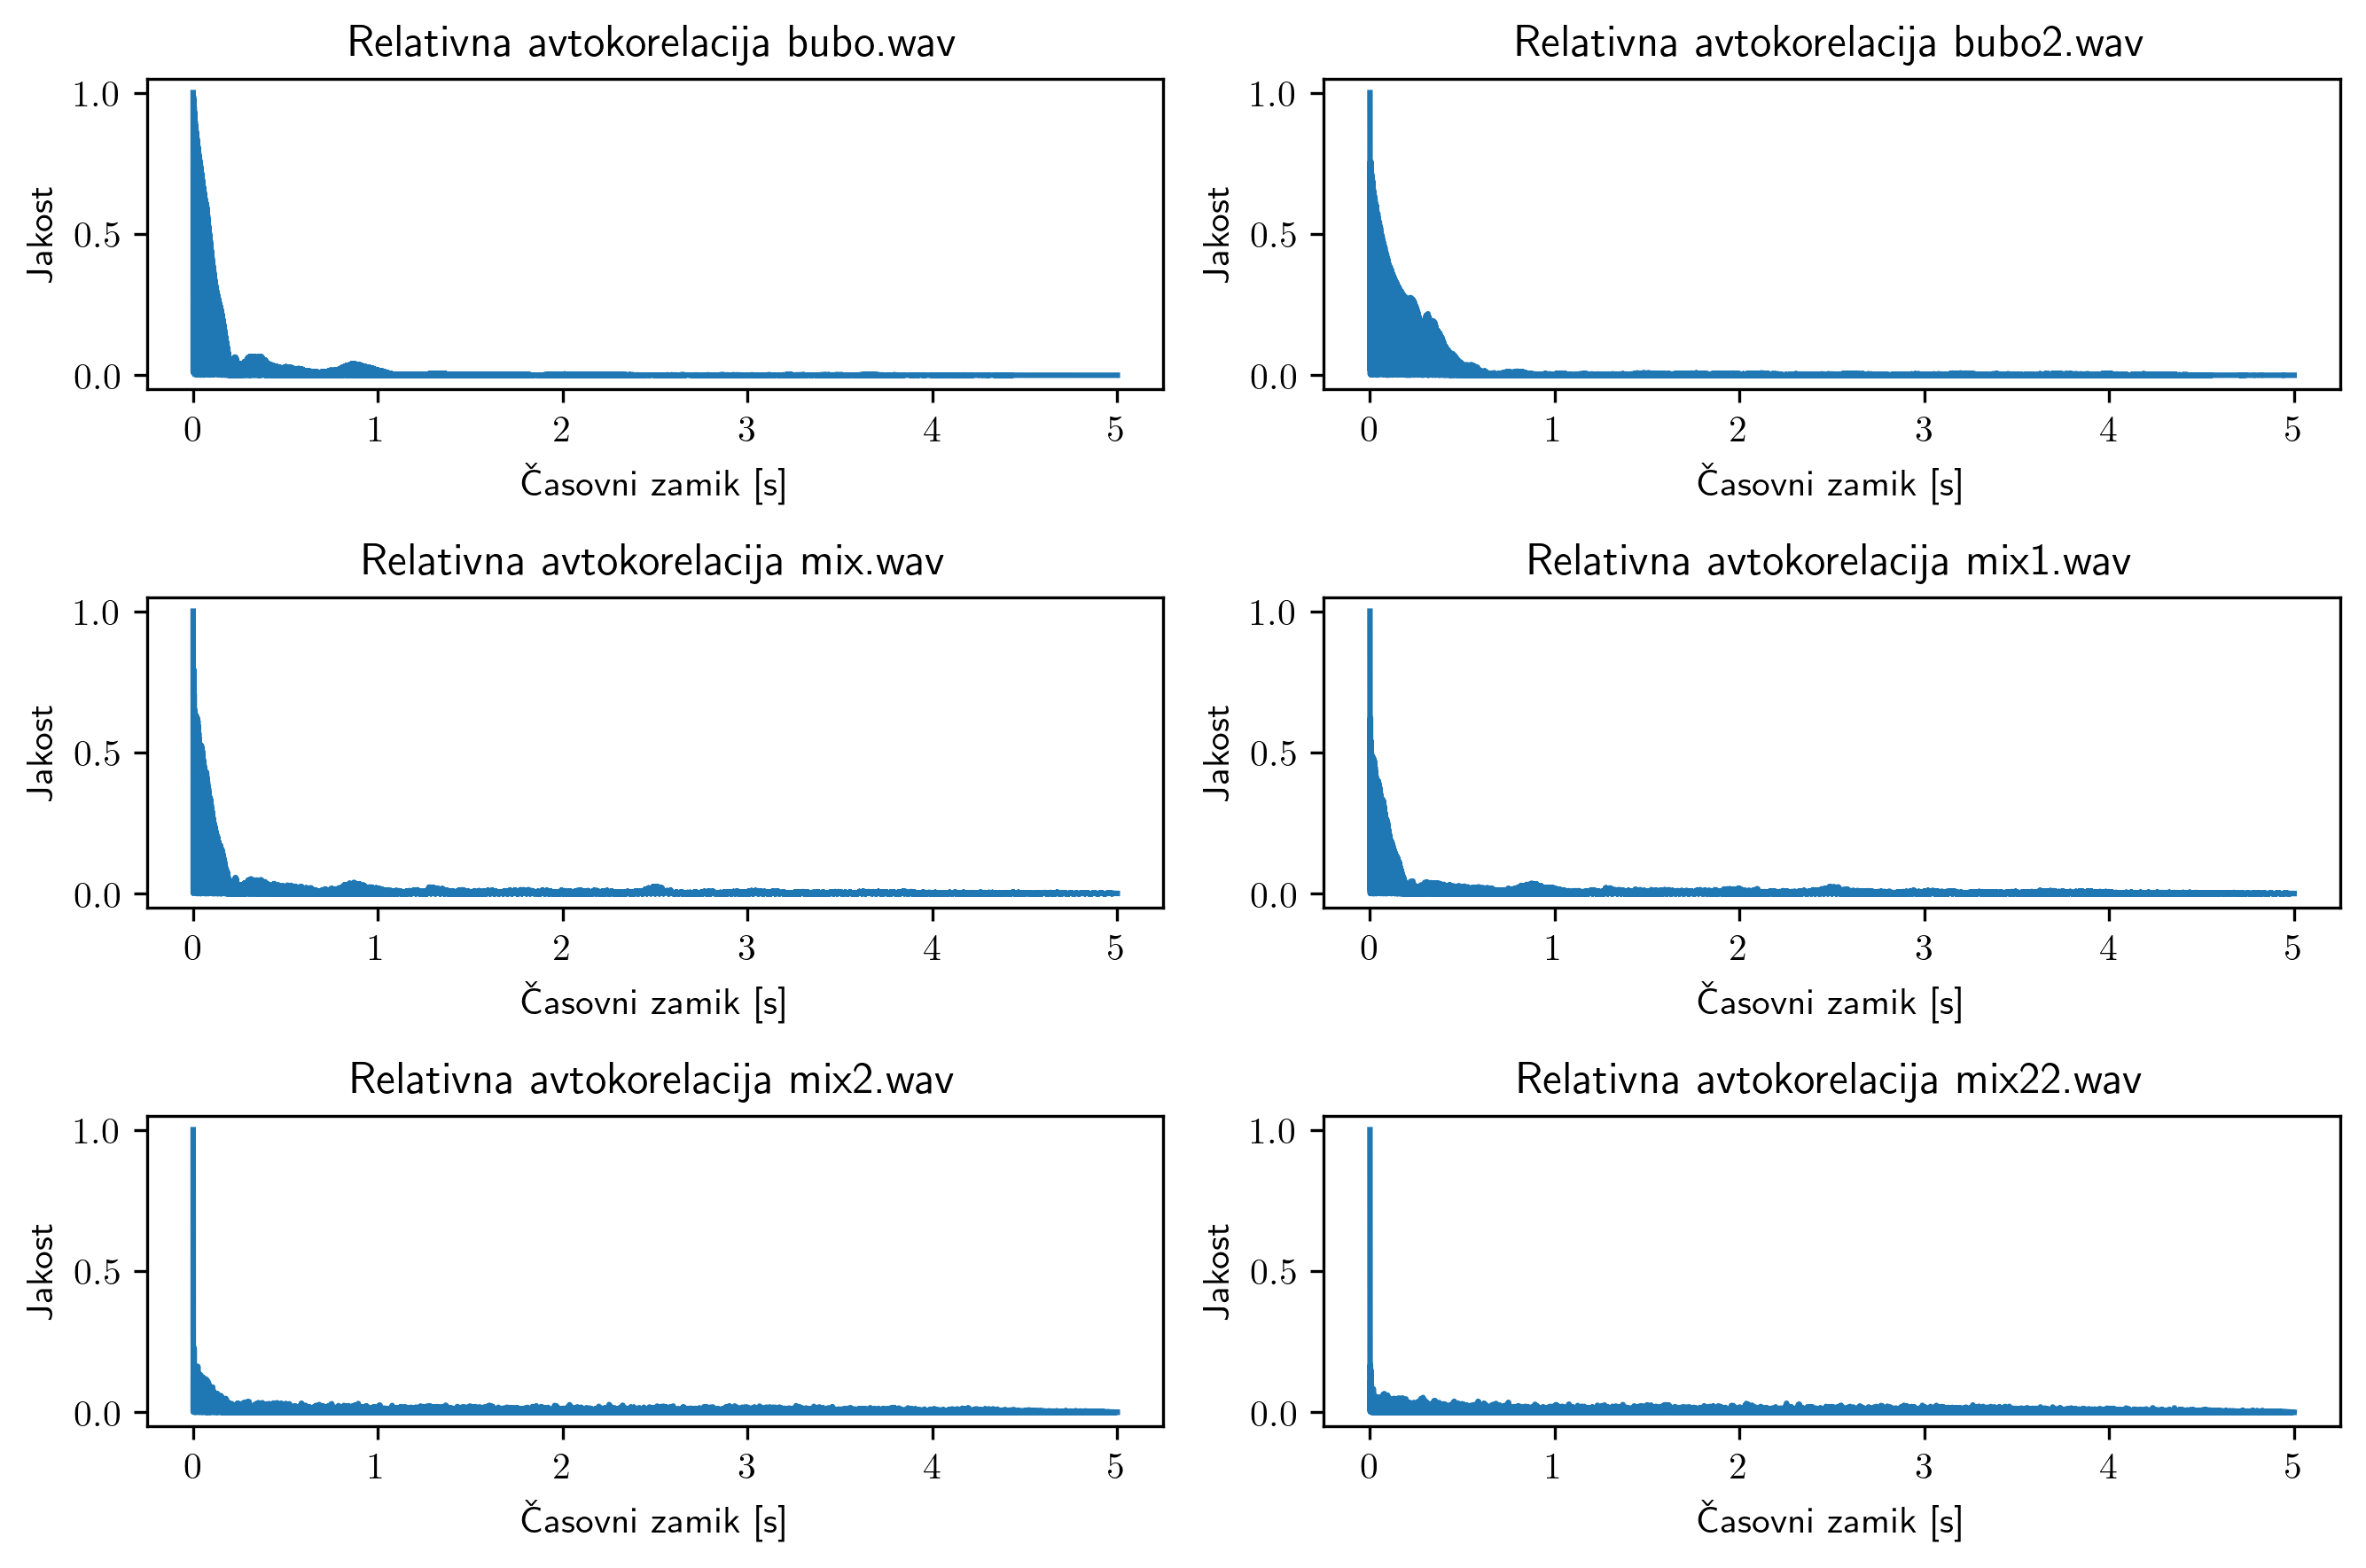

In [31]:
# Change of autocorrelation with time
fig, axes = plt.subplots(3, 2, figsize=(9, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):    
    sample_rate = sampling[i]
    ac_fft, ns_fft = auto_corr_fft_time(data[i])
    ac_fft = np.abs(ac_fft)
    ax.plot(ns_fft / sample_rate, ac_fft)
    ax.set_title(f'Relativna avtokorelacija {names[i]}.wav')
    ax.set_ylabel('Jakost')
    ax.set_xlabel('Časovni zamik [s]')

plt.tight_layout()

## Zaključek


---
Luka Skeledžija, [Github source 🔗](https://github.com/lukaske/mafijski-praktikum/tree/main/MFPR/04_discretefourier), 2023